# TGCN for SWM

### Through analysis and manual inspection from google satellite and streetview, 13 locations are found which are suspected to be dumping areas. This notebook aims to predict trend (number of different vehicles visiting) in these 13 locations on hourly basis. We will be using TGCN model for the purpose.

# Imports

In [1]:
#base_path='/content/drive/MyDrive/ITMS'
!pip install tensorflow>=2.10.0
!pip install h3
!pip install geopandas
!pip install stellargraph
!pip install spektral
!pip install h3pandas
!pip install git+https://github.com/datakaveri/iudx-python-sdk

  Using cached h3-3.7.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached geopandas-0.12.1-py3-none-any.whl (1.1 MB)
  Using cached pyproj-3.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.7 MB)
  Using cached Fiona-1.8.22-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached pandas-1.5.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached Shapely-1.8.5.post1-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
ERROR: Could not find a version that satisfies the requirement stellargraph (from versions: none)
ERROR: No matching distribution found for stellargraph
  Using cached spektral-1.2.0-py3-none-any.whl (140 kB)
  Using cached joblib-1.2.0-py3-

In [2]:
!pip install pyarrow
!pip install folium
!pip install seaborn
!pip install plotly

  Using cached pyarrow-10.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.9 MB)
  Using cached folium-0.13.0-py2.py3-none-any.whl (96 kB)
  Using cached branca-0.6.0-py3-none-any.whl (24 kB)
  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
  Using cached matplotlib-3.6.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached contourpy-1.0.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (296 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.3.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.3 MB)
  Using cached plotly-5.11.0-py2.py3-none-any.whl (15.3 MB)
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)


In [3]:
import math
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import time

import folium
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import h3
import h3pandas
import geopandas as gpd

from tqdm import tqdm
import json 
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

from scipy.spatial.distance import directed_hausdorff

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import os
import sys
import urllib.request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

#import stellargraph as sg
#from stellargraph.layer import GCN_LSTM

from spektral.utils import gcn_filter
from spektral.layers import GCNConv
import tensorflow
from tensorflow.keras.layers import Flatten

2022-12-08 09:59:19.005514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 09:59:19.089218: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 09:59:19.089235: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 09:59:19.553185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-0

In [4]:
!pip list> requirements.txt

# Data Loading and Preprocessing

In [6]:
data1 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_jan_1_10.parquet")
data2 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_jan_11_20.parquet")
data3 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_jan_21_31.parquet")
data4 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_feb_1_10.parquet")
data5 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_feb_11_20.parquet")
data6 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_feb_21_28.parquet")
data7 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_mar_1_10.parquet")
data8 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_mar_11_20.parquet")
bin_data = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_bin.parquet")
data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8],ignore_index=True)


In [7]:
data.head()

,license_plate,wardID,speed,vehicleType,observationDateTime,deviceBatteryStatus,vehicleRunningStatus,id,bearing,ignitionStatus,location.type,location.coordinates
0,UP65DT3327,0,43.0,Dumper,2021-12-31 18:30:00+00:00,Disconnected,Running,varanasismartcity.gov.in/62d1f729edd3d2a1a090c...,35.0,Y,Point,"[82.946685, 25.238207]"
1,UP65HT3953,0,41.0,Refused Compactor,2021-12-31 18:30:02+00:00,Connected,Running,varanasismartcity.gov.in/62d1f729edd3d2a1a090c...,38.0,Y,Point,"[82.95986, 25.2558]"
2,UP-65-KT-1063,65,0.0,Auto Tipper,2021-12-31 18:30:19+00:00,Disconnected,Idle,varanasismartcity.gov.in/62d1f729edd3d2a1a090c...,323.0,Y,Point,"[83.007242, 25.314905]"
3,UP65KT0865,33,0.0,Auto Tipper,2021-12-31 18:30:23+00:00,Disconnected,Idle,varanasismartcity.gov.in/62d1f729edd3d2a1a090c...,350.0,Y,Point,"[83.02515, 25.373368]"
4,UP-65-KT-0412,0,38.0,Dumper,2021-12-31 18:30:26+00:00,Disconnected,Running,varanasismartcity.gov.in/62d1f729edd3d2a1a090c...,212.0,Y,Point,"[82.921368, 25.224762]"


In [8]:
print(data.shape)
data = data.drop_duplicates()
print(data.shape)
print(bin_data.shape)
bin_data = bin_data.drop_duplicates()
print(bin_data.shape)

(2361320, 12)
(2227945, 12)
(816, 11)
(766, 11)


In [9]:
data['latitude']=data['location.coordinates'].apply(lambda x:float(x.split(",")[1][:-1].strip()))
data['longitude']=data['location.coordinates'].apply(lambda x:float(x.split(",")[0][1:].strip()))

bin_data['latitude']=bin_data['location.coordinates'].apply(lambda x:float(x.split(",")[1][:-1].strip()))
bin_data['longitude']=bin_data['location.coordinates'].apply(lambda x:float(x.split(",")[0][1:].strip()))

In [10]:
data.drop(["location.coordinates", "location.type","id"], axis=1, inplace=True)

# Since all bins have same capacity, colour category and fullness threshold.
bin_data.drop(["binCapacity", "id","binColor","binCategory", "binFullnessThreshold", "location.type", "location.coordinates"], axis=1, inplace=True)

In [11]:
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:x.tz_convert("Asia/Kolkata"))
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S%z'))
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:x.tz_localize(None))

In [12]:
data = data[data["latitude"]<=26]
data.reset_index(inplace=True)

In [13]:
#data_update=data
data_update=data[(data['observationDateTime']>='2022-01-01 00:00:00') & (data["observationDateTime"]<= '2022-03-15 23:59:59')]

# Calculating and Adding a column for h3 id in the data

In [14]:
temp=[]
for i in range(0,len(data_update)):
    temp.append(h3.geo_to_h3(data_update['latitude'].iloc[i], data_update['longitude'].iloc[i], resolution=9)) 
#data['h3_ids']=temp
data_update['h3_ids_9']=temp

# List of hex ids with possible dumping locations (resolution=9)

In [15]:
hex=['893c16454c3ffff',
'893c16454c7ffff',
'893c16454a3ffff',
'893c1645663ffff',
'893c1645243ffff',
'893c164524fffff',
'893c1645663ffff',
'893c1645637ffff',
'893c164562bffff',
'893c1644637ffff',
'893c16450d3ffff',
'893c164543bffff',
'893c16456a7ffff']
#hex=pd.DataFrame(hex)


# Filtering the Data

### Only the hex ids with the suspected dumping locations (stored in hex list) are considered and extracted from the original data

In [16]:
data2=pd.DataFrame()
count=0
for i in hex:
    count+=1
    data1=data_update[(data_update['h3_ids_9']==i)]
    data2=data2.append(data1,ignore_index=True)
    print(data2.shape)

(2345, 13)
(9102, 13)
(18219, 13)
(177447, 13)
(203214, 13)
(206878, 13)
(366106, 13)
(388202, 13)
(408751, 13)
(516493, 13)
(533133, 13)
(538629, 13)
(545287, 13)


In [17]:
np.unique(data2['h3_ids_9'])

array(['893c1644637ffff', '893c16450d3ffff', '893c1645243ffff',
       '893c164524fffff', '893c164543bffff', '893c16454a3ffff',
       '893c16454c3ffff', '893c16454c7ffff', '893c164562bffff',
       '893c1645637ffff', '893c1645663ffff', '893c16456a7ffff'],
      dtype=object)

In [18]:
def datespan(startDate, endDate, delta=timedelta(days=1)):
    currentDate = startDate
    while currentDate < endDate:
        yield currentDate
        currentDate += delta


### Splitting the data on hourly basis

In [19]:
temp3=[]
for i in hex:
    temp2=[]
    for timestamp in datespan(datetime(2022, 1, 1, 00, 00), datetime(2022, 3, 15, 23,59 ),delta=timedelta(hours=1)):
        data_single_vehicle=data2[(data2['h3_ids_9']==i) &(data2["observationDateTime"]>= str(timestamp)) & (data2["observationDateTime"]<= str(timestamp+timedelta(minutes=59)))]
        x=len(np.unique(data_single_vehicle['license_plate']))
        temp2.append([str(timestamp),x])
    temp3.append([i,temp2])

In [20]:
np.unique(data2['h3_ids_9'])

array(['893c1644637ffff', '893c16450d3ffff', '893c1645243ffff',
       '893c164524fffff', '893c164543bffff', '893c16454a3ffff',
       '893c16454c3ffff', '893c16454c7ffff', '893c164562bffff',
       '893c1645637ffff', '893c1645663ffff', '893c16456a7ffff'],
      dtype=object)

In [21]:
temp3=pd.DataFrame(temp3)
temp3

,0,1
0,893c16454c3ffff,"[[2022-01-01 00:00:00, 1], [2022-01-01 01:00:0..."
1,893c16454c7ffff,"[[2022-01-01 00:00:00, 2], [2022-01-01 01:00:0..."
2,893c16454a3ffff,"[[2022-01-01 00:00:00, 2], [2022-01-01 01:00:0..."
3,893c1645663ffff,"[[2022-01-01 00:00:00, 10], [2022-01-01 01:00:..."
4,893c1645243ffff,"[[2022-01-01 00:00:00, 0], [2022-01-01 01:00:0..."
5,893c164524fffff,"[[2022-01-01 00:00:00, 0], [2022-01-01 01:00:0..."
6,893c1645663ffff,"[[2022-01-01 00:00:00, 10], [2022-01-01 01:00:..."
7,893c1645637ffff,"[[2022-01-01 00:00:00, 3], [2022-01-01 01:00:0..."
8,893c164562bffff,"[[2022-01-01 00:00:00, 2], [2022-01-01 01:00:0..."
9,893c1644637ffff,"[[2022-01-01 00:00:00, 4], [2022-01-01 01:00:0..."


In [22]:
temp3.iloc[11][1][1775]

['2022-03-15 23:00:00', 3]

In [23]:
for j in range(0,1776):
  temp4=[]
  for i in range(0,13):
    temp4.append(temp3.iloc[i][1][j][1])
  temp3[str(temp3.iloc[i][1][j][0])]=temp4

In [24]:
temp3.drop(1,inplace=True,axis=1)
temp3

,0,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 02:00:00,2022-01-01 03:00:00,2022-01-01 04:00:00,2022-01-01 05:00:00,2022-01-01 06:00:00,2022-01-01 07:00:00,2022-01-01 08:00:00,...,2022-03-15 14:00:00,2022-03-15 15:00:00,2022-03-15 16:00:00,2022-03-15 17:00:00,2022-03-15 18:00:00,2022-03-15 19:00:00,2022-03-15 20:00:00,2022-03-15 21:00:00,2022-03-15 22:00:00,2022-03-15 23:00:00
0,893c16454c3ffff,1,0,0,0,0,0,0,0,4,...,0,0,1,1,1,1,0,1,0,0
1,893c16454c7ffff,2,1,3,0,0,0,0,4,4,...,3,1,1,1,1,1,0,1,0,2
2,893c16454a3ffff,2,3,3,1,0,0,1,4,8,...,4,1,1,1,1,1,6,2,3,3
3,893c1645663ffff,10,7,7,7,5,9,10,35,27,...,8,12,14,11,12,14,13,13,7,10
4,893c1645243ffff,0,1,1,4,1,1,1,6,4,...,2,4,1,3,5,5,6,0,0,0
5,893c164524fffff,0,1,0,1,0,0,0,1,1,...,0,1,0,2,1,0,3,0,0,0
6,893c1645663ffff,10,7,7,7,5,9,10,35,27,...,8,12,14,11,12,14,13,13,7,10
7,893c1645637ffff,3,1,1,0,0,0,0,4,12,...,2,0,1,0,0,0,3,2,3,3
8,893c164562bffff,2,2,1,2,0,0,1,13,18,...,2,1,1,0,0,0,5,6,1,2
9,893c1644637ffff,4,4,3,5,4,4,5,24,7,...,20,8,5,6,9,8,7,4,5,5


In [25]:
temp3=temp3.set_index(0)

In [26]:
temp3.index.names=[None]
temp3

,2022-01-01 00:00:00,2022-01-01 01:00:00,2022-01-01 02:00:00,2022-01-01 03:00:00,2022-01-01 04:00:00,2022-01-01 05:00:00,2022-01-01 06:00:00,2022-01-01 07:00:00,2022-01-01 08:00:00,2022-01-01 09:00:00,...,2022-03-15 14:00:00,2022-03-15 15:00:00,2022-03-15 16:00:00,2022-03-15 17:00:00,2022-03-15 18:00:00,2022-03-15 19:00:00,2022-03-15 20:00:00,2022-03-15 21:00:00,2022-03-15 22:00:00,2022-03-15 23:00:00
893c16454c3ffff,1,0,0,0,0,0,0,0,4,0,...,0,0,1,1,1,1,0,1,0,0
893c16454c7ffff,2,1,3,0,0,0,0,4,4,3,...,3,1,1,1,1,1,0,1,0,2
893c16454a3ffff,2,3,3,1,0,0,1,4,8,6,...,4,1,1,1,1,1,6,2,3,3
893c1645663ffff,10,7,7,7,5,9,10,35,27,6,...,8,12,14,11,12,14,13,13,7,10
893c1645243ffff,0,1,1,4,1,1,1,6,4,1,...,2,4,1,3,5,5,6,0,0,0
893c164524fffff,0,1,0,1,0,0,0,1,1,4,...,0,1,0,2,1,0,3,0,0,0
893c1645663ffff,10,7,7,7,5,9,10,35,27,6,...,8,12,14,11,12,14,13,13,7,10
893c1645637ffff,3,1,1,0,0,0,0,4,12,5,...,2,0,1,0,0,0,3,2,3,3
893c164562bffff,2,2,1,2,0,0,1,13,18,5,...,2,1,1,0,0,0,5,6,1,2
893c1644637ffff,4,4,3,5,4,4,5,24,7,5,...,20,8,5,6,9,8,7,4,5,5


In [27]:
#temp3.to_csv('temp3_for_tgcn_hex.csv')

In [28]:
#temp3=pd.read_csv('temp3_for_tgcn_hex.csv')

In [29]:
temp3.max().max()

61

# Adjacency and Feature Matrix

### The idea behind calculating the adjacency matrix is: All the hexagons that have the same parent hexagon (in our case the resolution of parent hexagon is 8) are neighbours and will be marked as 1. This idea will help in correlating the non-neighbouring dumping hexes.

In [30]:
def get_adjacency_matrix(hexes):
  adj=[]
  for hex1 in hexes:
    row=[]
    for hex2 in hexes:
      if h3.h3_to_parent(hex2, 8) == h3.h3_to_parent(hex1, 8):
        row.append(1)
      else:
        row.append(0)
    adj.append(row)
  adj_mat=np.array(adj)
  return adj_mat

In [31]:
adj_mat=get_adjacency_matrix(hex)

In [32]:
adj_mat

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

# Utility Functions

In [33]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

def scale_data(train_data, test_data):
    max_count = 61
    min_count = 0
    train_scaled = (train_data - min_count) / (max_count - min_count)
    test_scaled = (test_data - min_count) / (max_count - min_count)
    return train_scaled, test_scaled

def unscale_data(data_scaled):
  max_count=61
  min_count=0
  data_unscaled=(data_scaled*(max_count-min_count))+min_count
  return data_unscaled

def sequence_data_preparation1(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

def sequence_data_preparation2(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []
    trainX_nf, testX_nf = [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        
        trainX_nf.append([[np.average(x[:seq_len])] for x in a])
        trainX.append(np.reshape(a[:, :seq_len],(seq_len,a.shape[0])))
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX_nf.append([[np.average(x[:seq_len])] for x in b])
        testX.append(np.reshape(b[:, :seq_len],(seq_len,b.shape[0])))
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainX_nf = np.array(trainX_nf)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testX_nf = np.array(testX_nf)
    testY = np.array(testY)

    return trainX, trainX_nf, trainY, testX, testX_nf, testY

def clean_prediction(prediction):
  for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
      if prediction[i,j]<0:
        prediction[i,j]=-1
  return prediction

# Data Preperation, Model Training and Evaluation

### Data prep

In [138]:
train_rate = 0.85
train_data, test_data = train_test_split(temp3, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

train_scaled, test_scaled = scale_data(train_data, test_data)

seq_len = 12
pre_len = 1

trainX, trainY, testX, testY = sequence_data_preparation1(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
# print(trainX_nf.shape)
print(trainY.shape)
print(testX.shape)
# print(testX_nf.shape)
print(testY.shape)
test_ex_per_hour=testY.shape[0]



Train data:  (13, 1509)
Test data:  (13, 267)
(1497, 13, 12)
(1497, 13)
(255, 13, 12)
(255, 13)
                 2022-01-01 00:00:00  2022-01-01 01:00:00  \
893c16454c3ffff                    1                    0   
893c16454c7ffff                    2                    1   
893c16454a3ffff                    2                    3   
893c1645663ffff                   10                    7   
893c1645243ffff                    0                    1   
893c164524fffff                    0                    1   
893c1645663ffff                   10                    7   
893c1645637ffff                    3                    1   
893c164562bffff                    2                    2   
893c1644637ffff                    4                    4   
893c16450d3ffff                    6                    3   
893c164543bffff                    0                    1   
893c16456a7ffff                    4                    2   

                 2022-01-01 02:00:00  2022-01-01 

In [35]:
adj_lap=gcn_filter(adj_mat, symmetric=True)
N=len(hex)
opt = Adam(learning_rate=0.001)

2022-11-30 06:50:13.955283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-30 06:50:13.955537: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 06:50:13.955560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-admin): /proc/driver/nvidia/version does not exist
2022-11-30 06:50:13.957878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Building the model

In [36]:

#inp_seq = Input((seq_len, N))
# inp_lap = Input((N,N))
inp_feat = Input((N, trainX.shape[-1]))

x = GCNConv(32, activation='relu')([inp_feat, adj_lap])
x = GCNConv(16, activation='relu')([x, adj_lap])
x = Reshape((16,N))(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = LSTM(32, activation='relu')(x)

# x = Concatenate()([x,xx])
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(N)(x)

model = Model(inp_feat, out)
model.compile(optimizer=opt, loss='mse', 
              metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 12)]          0         
                                                                 
 gcn_conv (GCNConv)          (None, 13, 32)            416       
                                                                 
 gcn_conv_1 (GCNConv)        (None, 13, 16)            528       
                                                                 
 reshape (Reshape)           (None, 16, 13)            0         
                                                                 
 lstm (LSTM)                 (None, 16, 128)           72704     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 128)               4224  

### Model training and evaluation

In [121]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=100,
                                            restore_best_weights=True)
history=model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=32,
    shuffle=True,
    verbose=1,
    validation_data=(testX, testY),
    callbacks=[callback]
)
y_true=unscale_data(testY)


y_pred=clean_prediction(unscale_data(model.predict(testX)))

print(f'MSE:{mean_squared_error(y_true, y_pred)}')
print(f'RMSE:{math.sqrt(mean_squared_error(y_true, y_pred))}')
print(f'R-squared:{r2_score(y_true, y_pred)}')
print(f'MAE:{mean_absolute_error(y_true, y_pred)}')

#sg.utils.plot_history(history)
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

Epoch 1/100
47/47 [==============================] - 1s 15ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 2/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 3/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 4/100
47/47 [==============================] - 1s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 5/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 6/100
47/47 [==============================] - 1s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0025 - val_

NameError: name 'textX' is not defined

In [128]:
y_pred=clean_prediction(unscale_data(model.predict(testX)))
print(testX[0])

8/8 [==============================] - 0s 5ms/step
[[0.         0.01639344 0.         0.01639344 0.         0.
  0.         0.         0.         0.         0.01639344 0.01639344]
 [0.04918033 0.01639344 0.03278689 0.03278689 0.         0.03278689
  0.03278689 0.         0.         0.03278689 0.08196721 0.04918033]
 [0.04918033 0.03278689 0.08196721 0.03278689 0.03278689 0.04918033
  0.03278689 0.         0.01639344 0.01639344 0.06557377 0.08196721]
 [0.24590164 0.21311475 0.21311475 0.19672131 0.19672131 0.26229508
  0.21311475 0.21311475 0.21311475 0.19672131 0.8852459  0.18032787]
 [0.01639344 0.         0.13114754 0.03278689 0.01639344 0.
  0.         0.06557377 0.06557377 0.09836066 0.09836066 0.13114754]
 [0.         0.         0.08196721 0.         0.         0.
  0.         0.         0.01639344 0.01639344 0.         0.04918033]
 [0.24590164 0.21311475 0.21311475 0.19672131 0.19672131 0.26229508
  0.21311475 0.21311475 0.21311475 0.19672131 0.8852459  0.18032787]
 [0.03278689 0

In [131]:
print(testX.shape)

(255, 13, 12)


# Visualizing the results

### Plots representing the true and predicted values of the 13 hexes

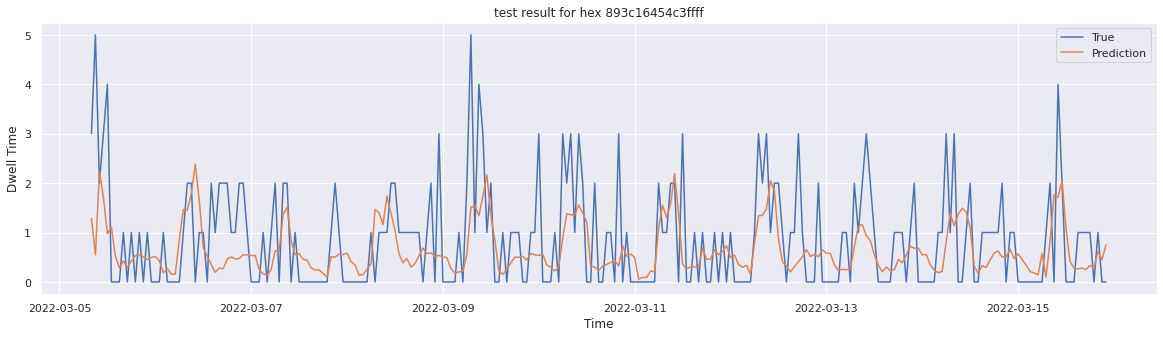

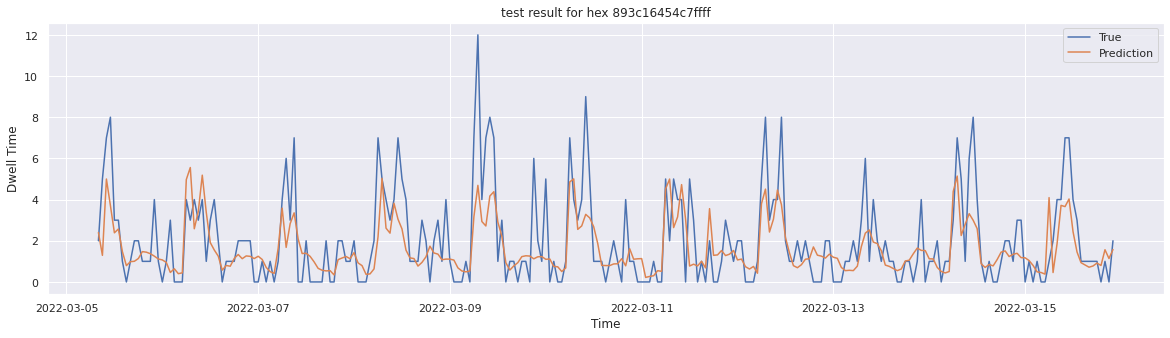

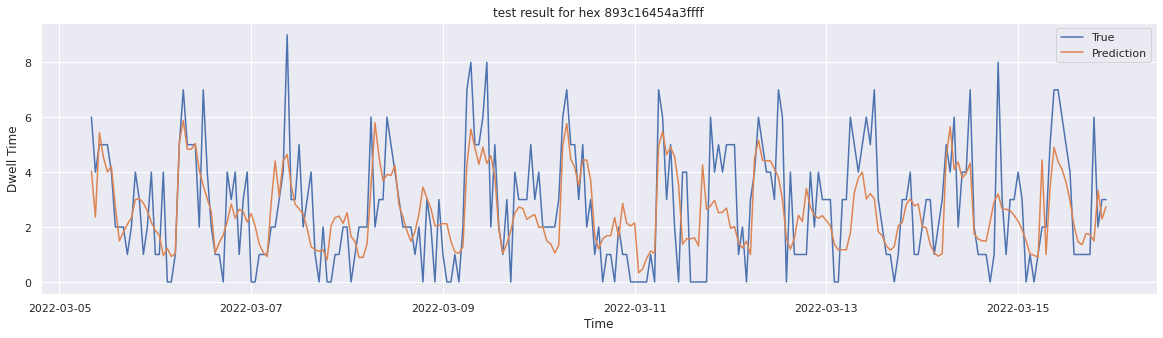

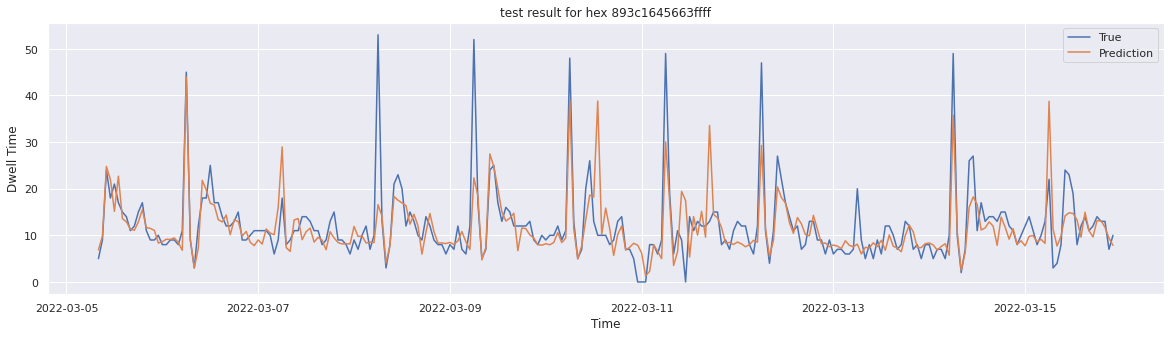

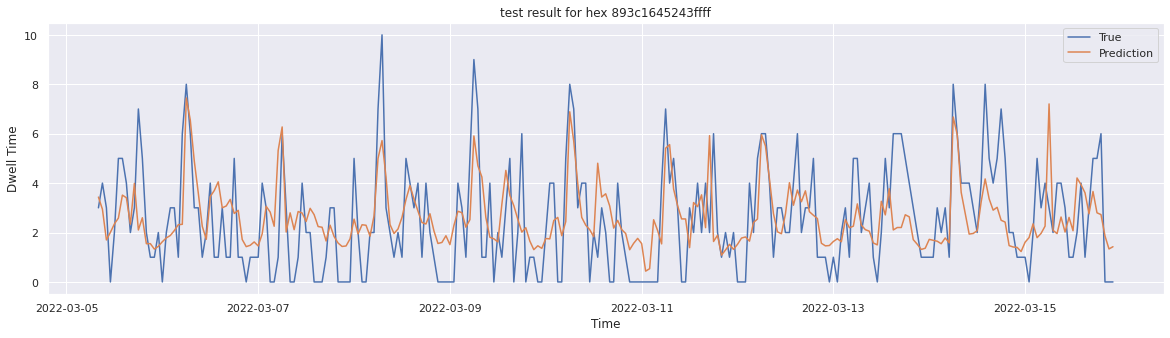

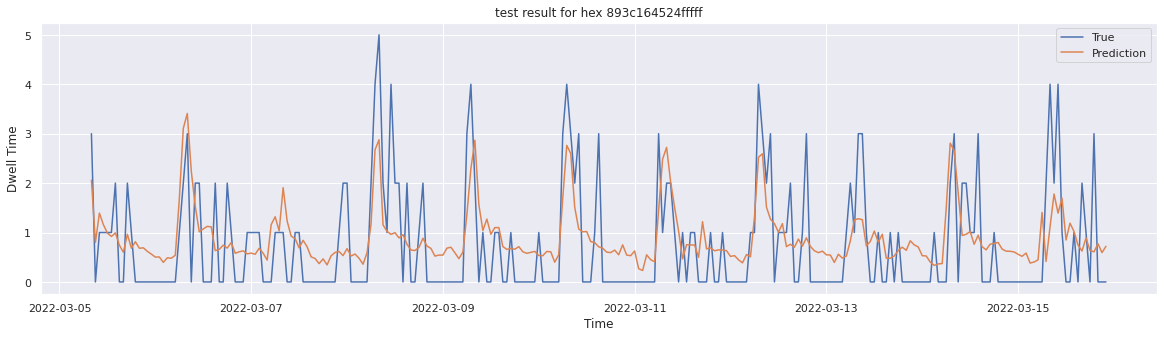

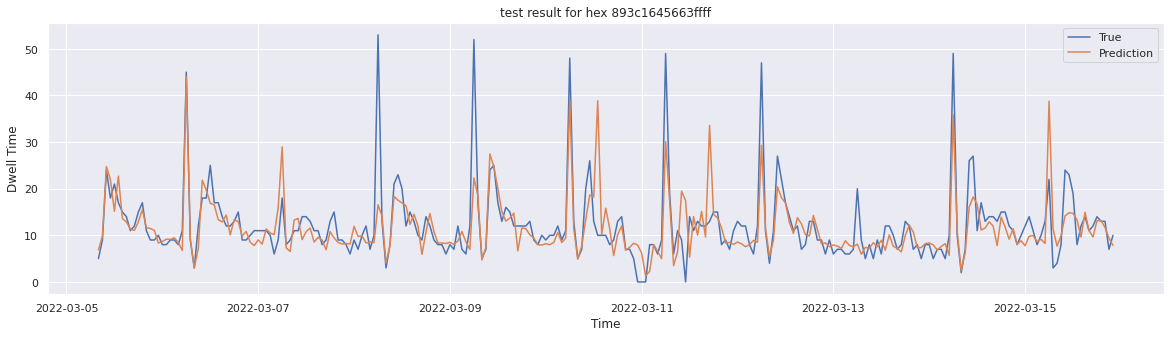

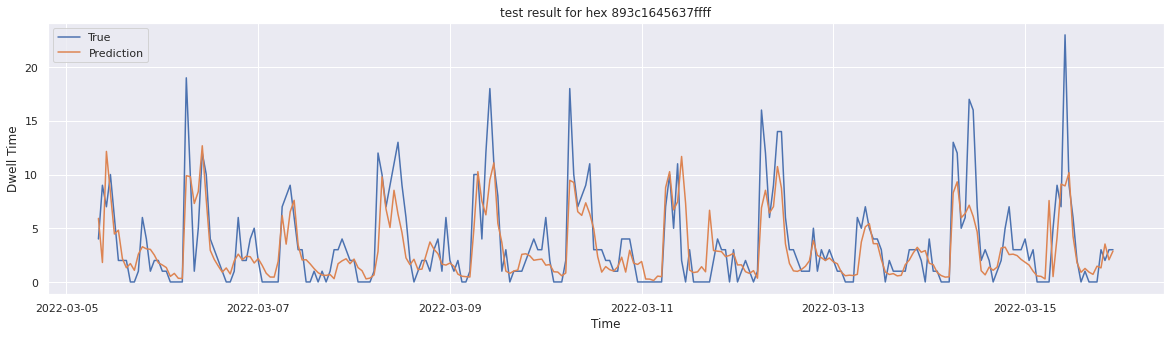

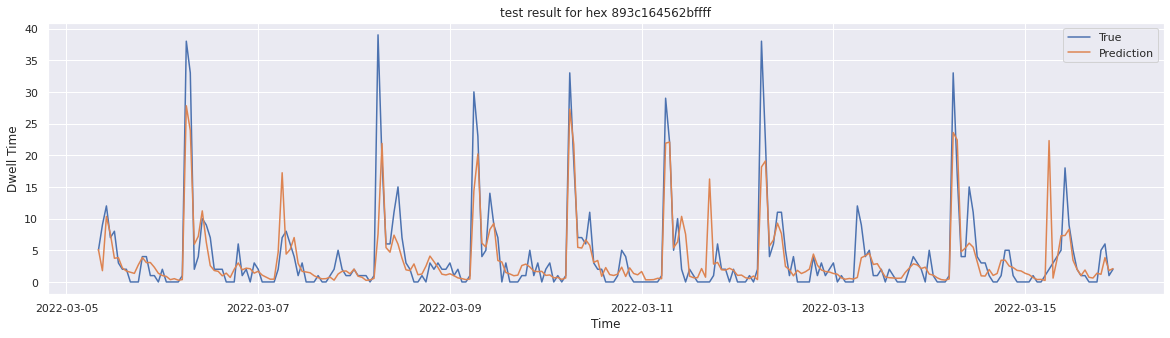

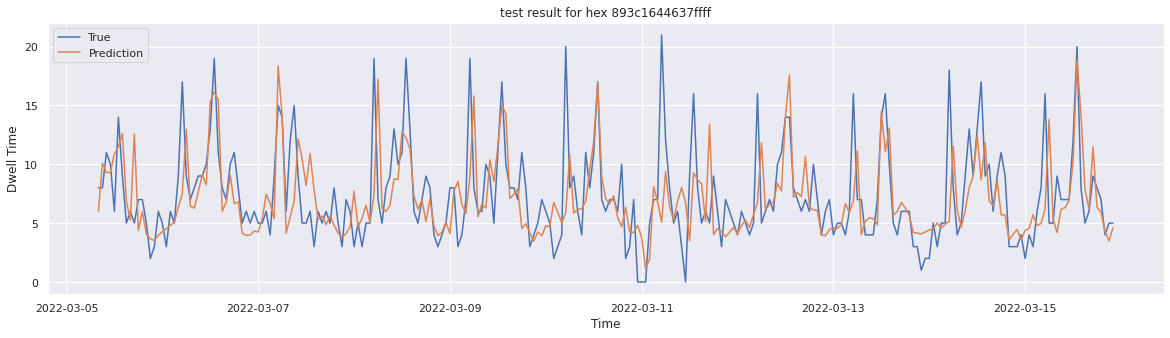

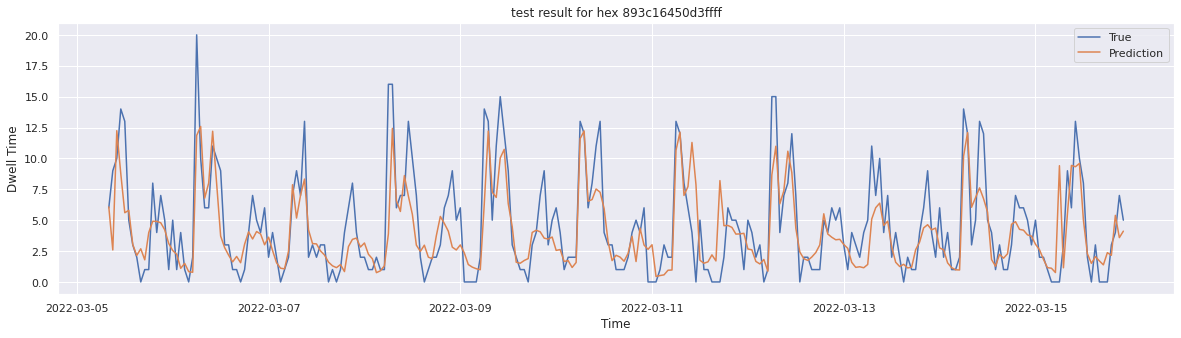

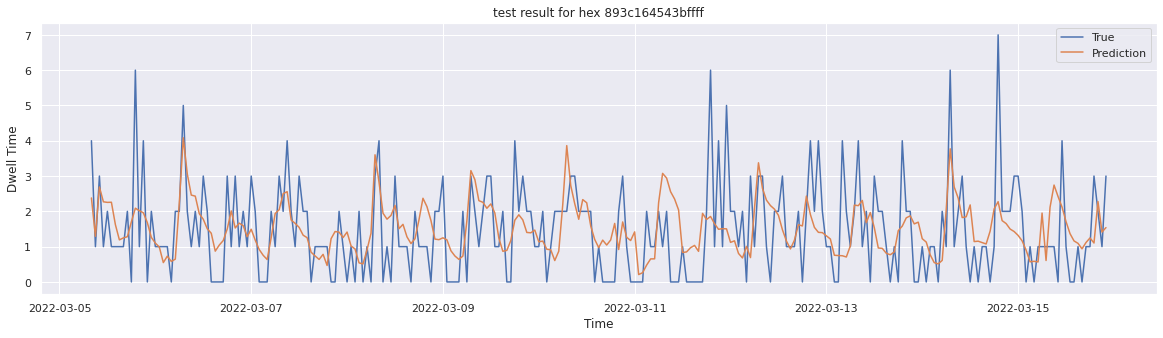

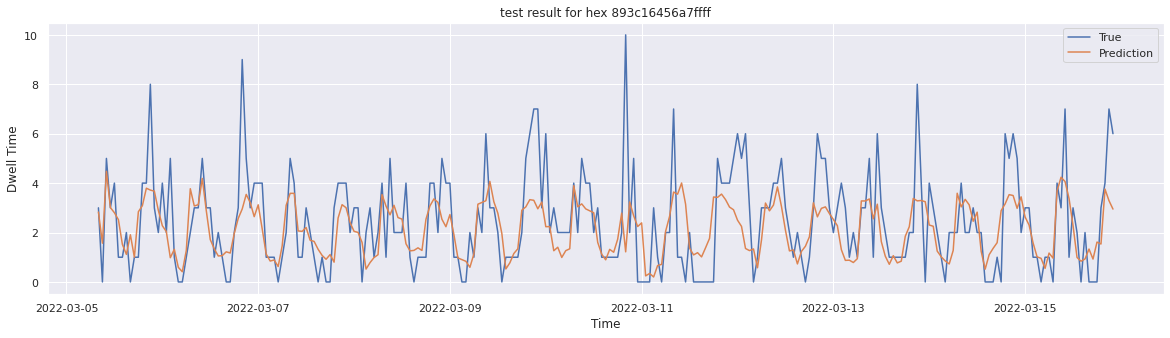

In [126]:
start_date=datetime(2022,3,15,23)-timedelta(hours=test_ex_per_hour)
x=[start_date+timedelta(hours=i) for i in range(0,test_ex_per_hour)]
for index in range(0,13):
  a_true=y_true[:,index]
  a_pred=y_pred[:,index]
  plt.figure(figsize=(20,5))
  sns.lineplot(y=a_true,x=x,label='True')
  sns.lineplot(y=a_pred,x=x,label='Prediction')
  plt.title(f'test result for hex {hex[index]}')
  plt.xlabel('Time')
  plt.ylabel('Dwell Time')
  plt.show()

### Difference in true and predicted values

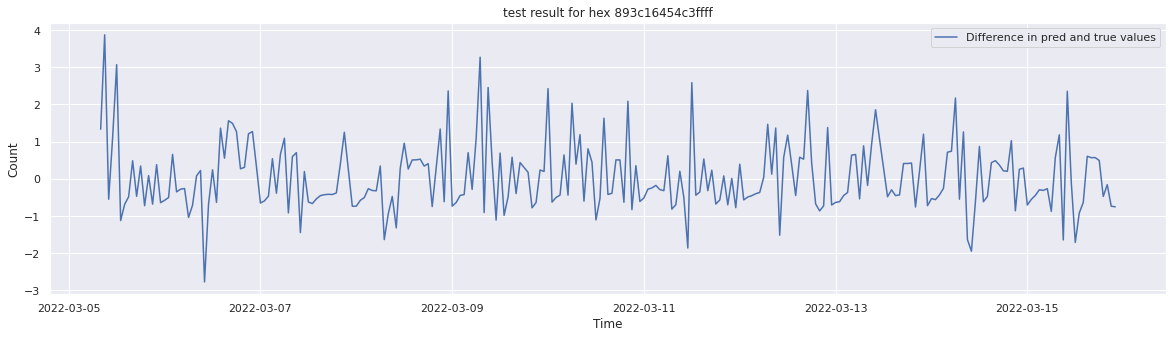

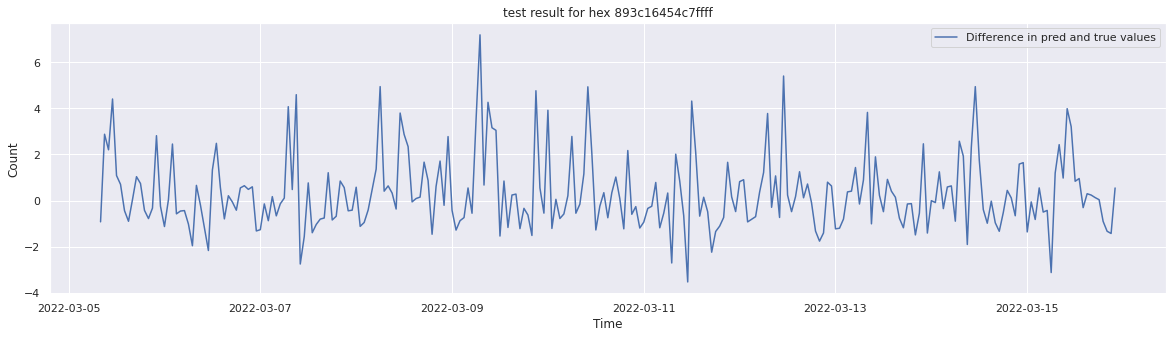

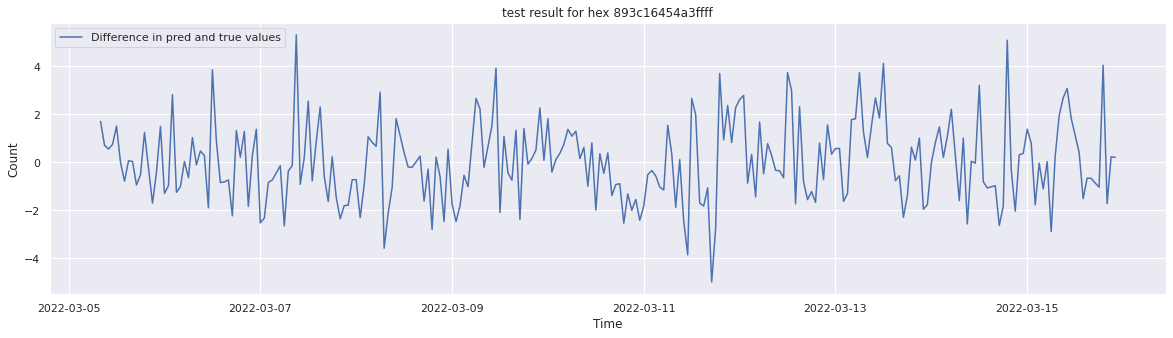

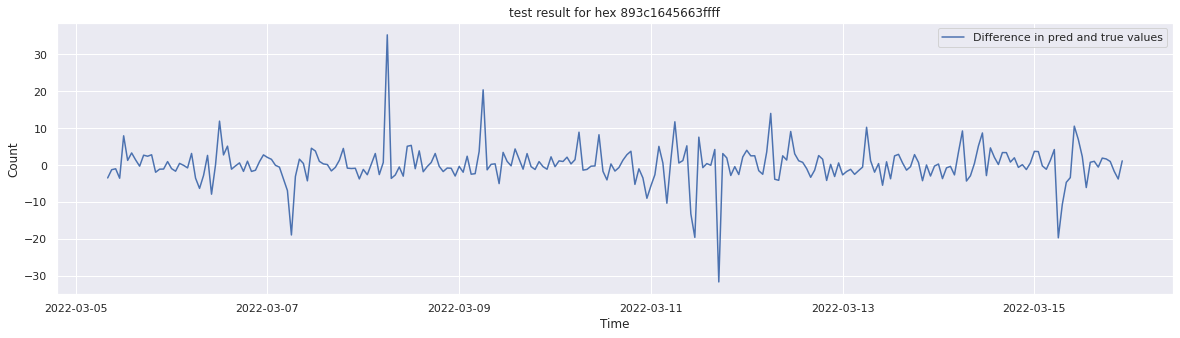

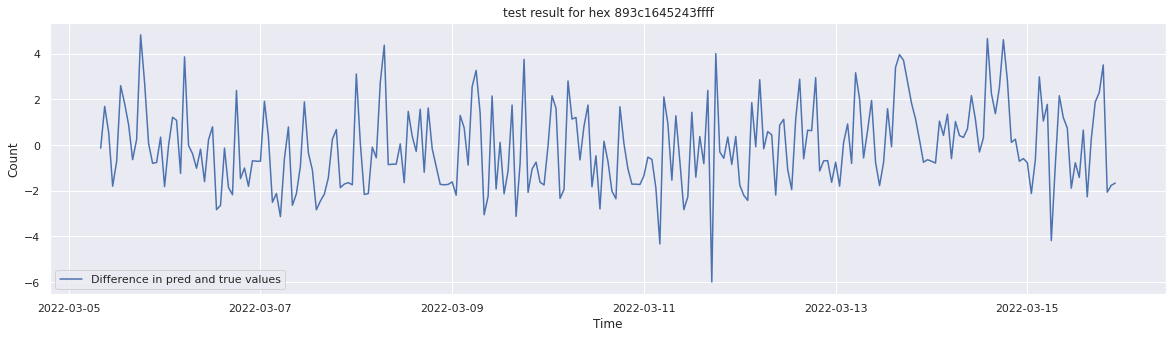

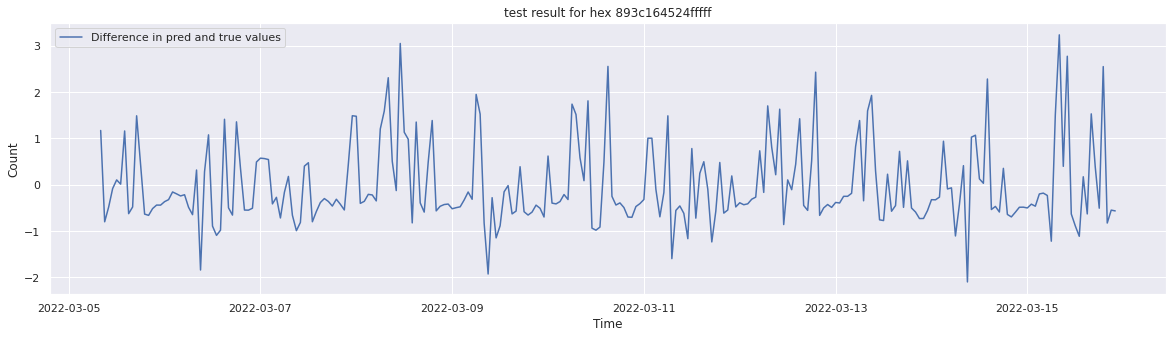

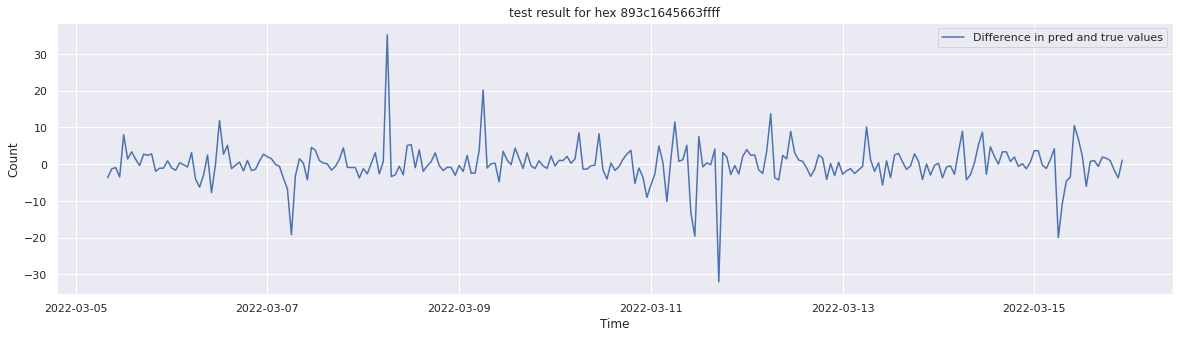

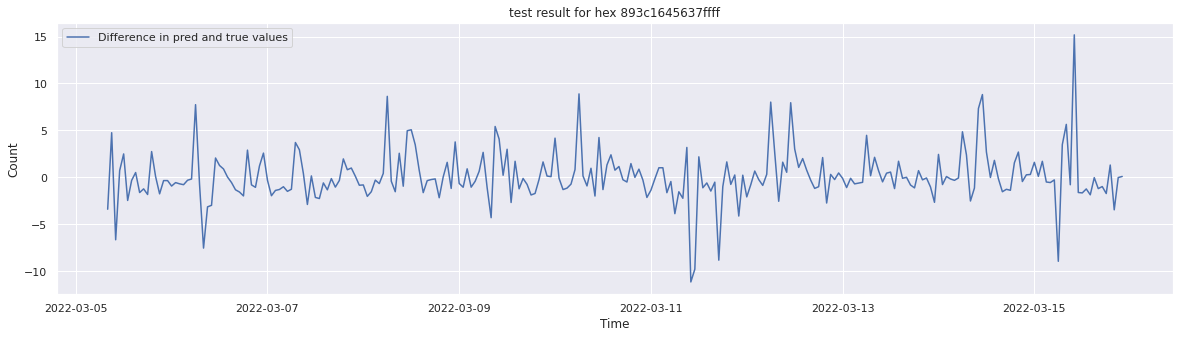

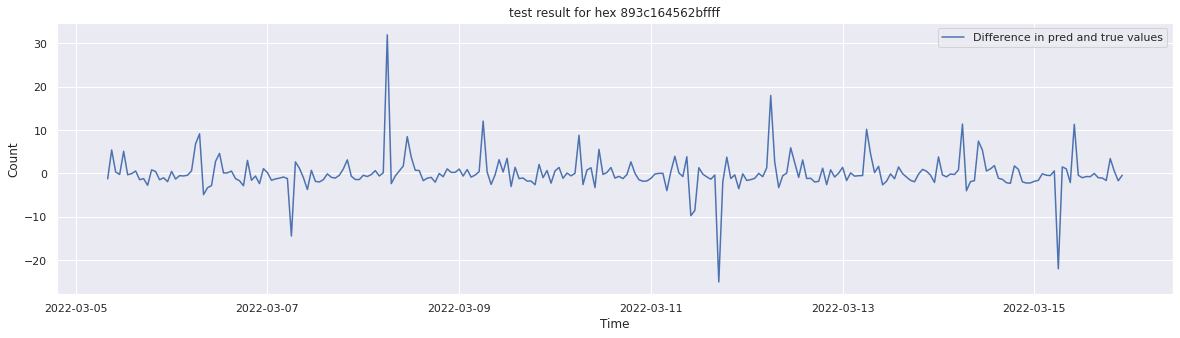

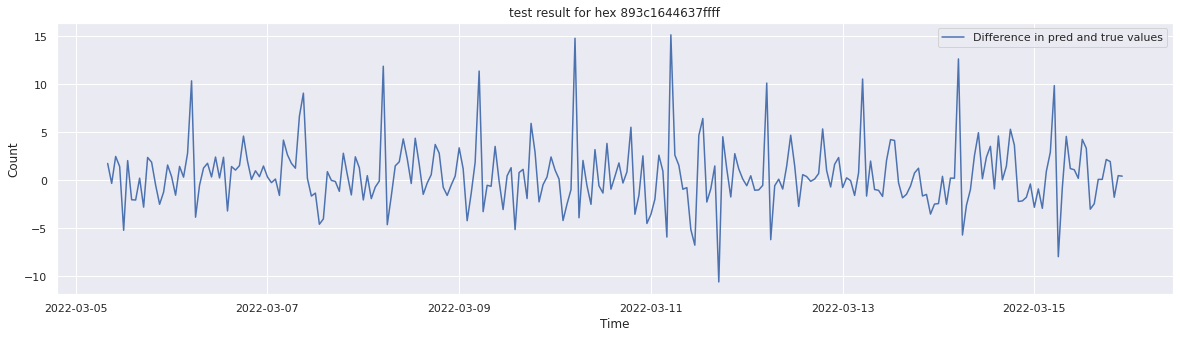

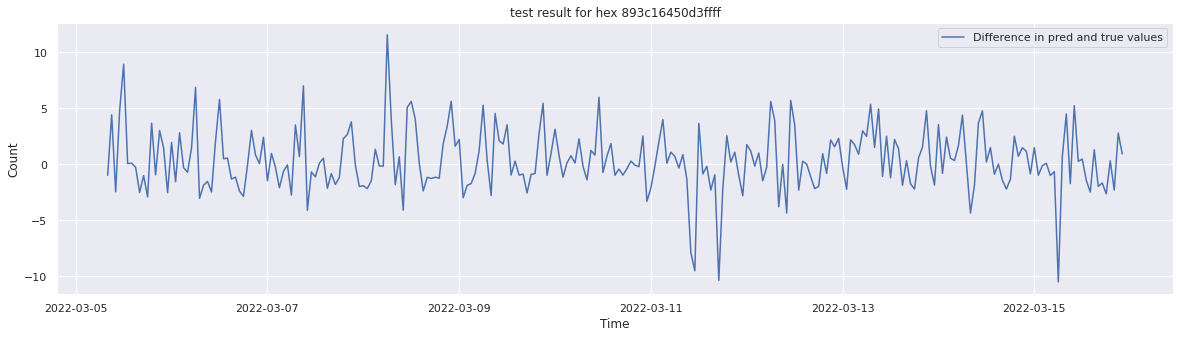

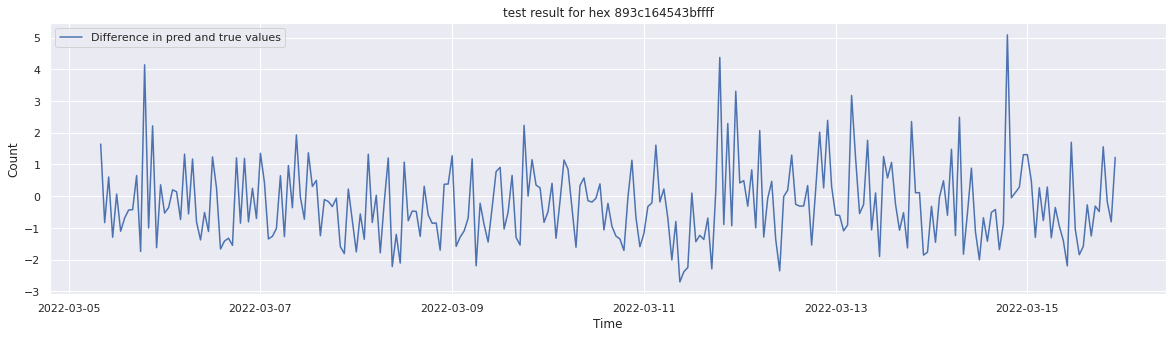

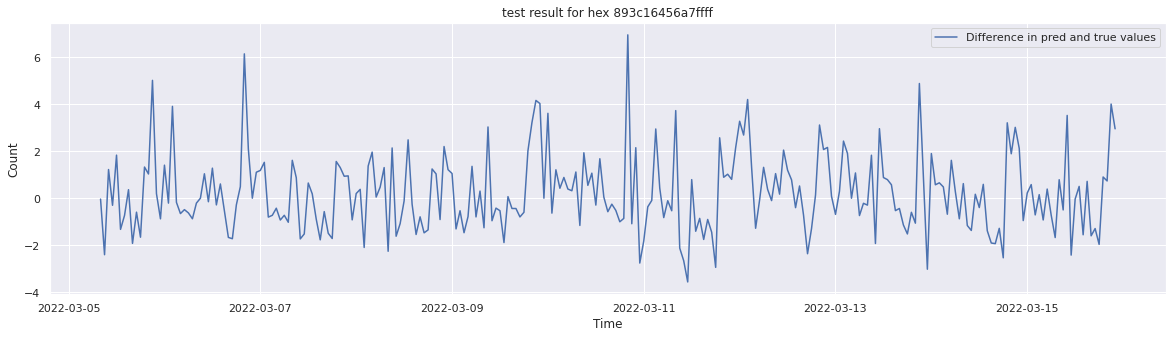

In [111]:
start_date=datetime(2022,3,15,23)-timedelta(hours=test_ex_per_hour)
x=[start_date+timedelta(hours=i) for i in range(0,test_ex_per_hour)]
diff_data = np.empty([len(x),13])


for index in range(0,13):
  a_true=y_true[:,index]
  a_pred=y_pred[:,index]
  y1=(a_true-a_pred)
  diff_data[:,index] = y1
  plt.figure(figsize=(20,5))
  sns.lineplot(y=y1,x=x,label='Difference in pred and true values')
  plt.title(f'test result for hex {hex[index]}')
  plt.xlabel('Time')
  plt.ylabel('Count')
  plt.show()

In [40]:
def differential(time_series):
    diff=list()
    for i in range(1,len(time_series)):
        temp= time_series[i]-time_series[i-1]
        diff.append(temp)
    diff=np.array(diff)
    return diff

### Plots with difference between  the time differential of true and predicted values 

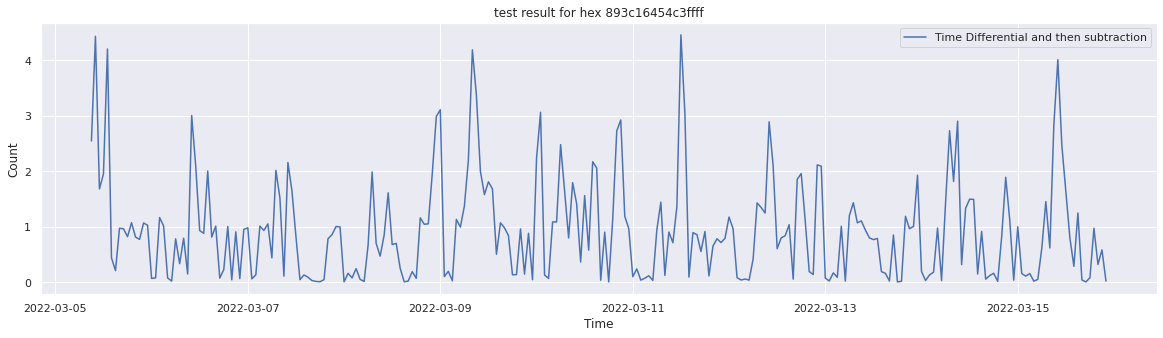

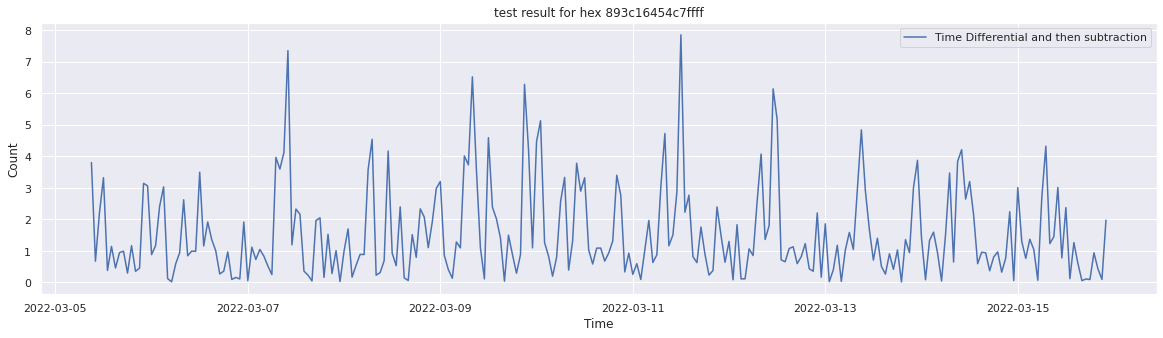

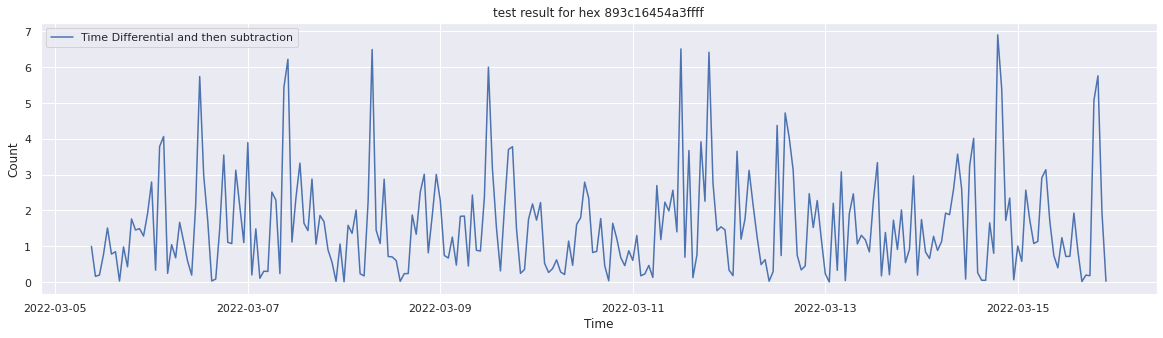

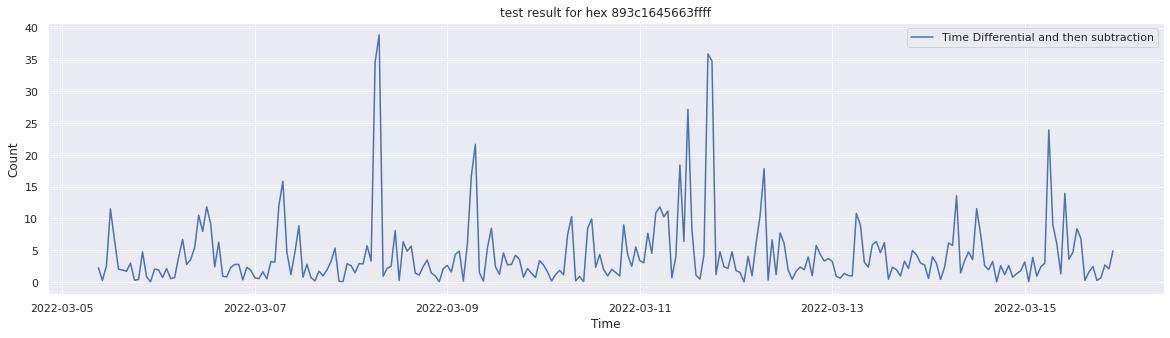

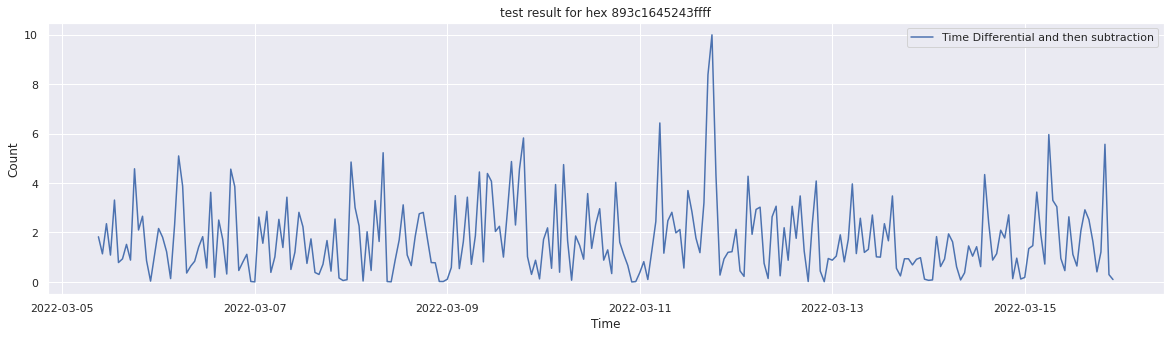

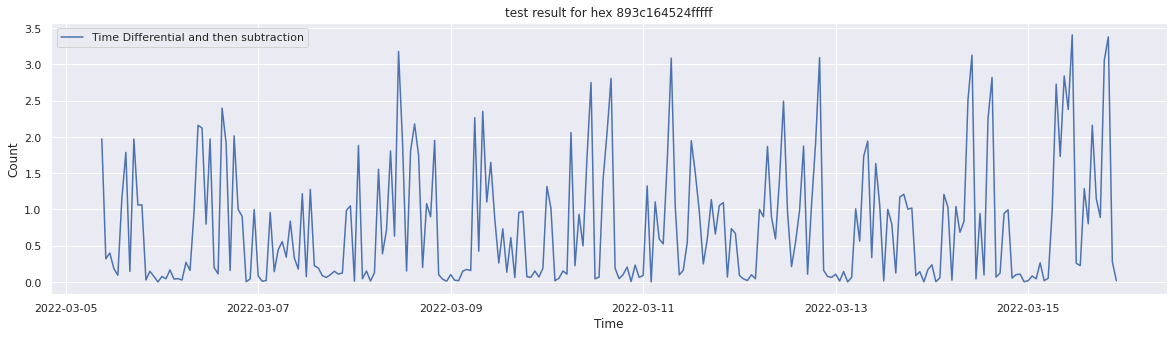

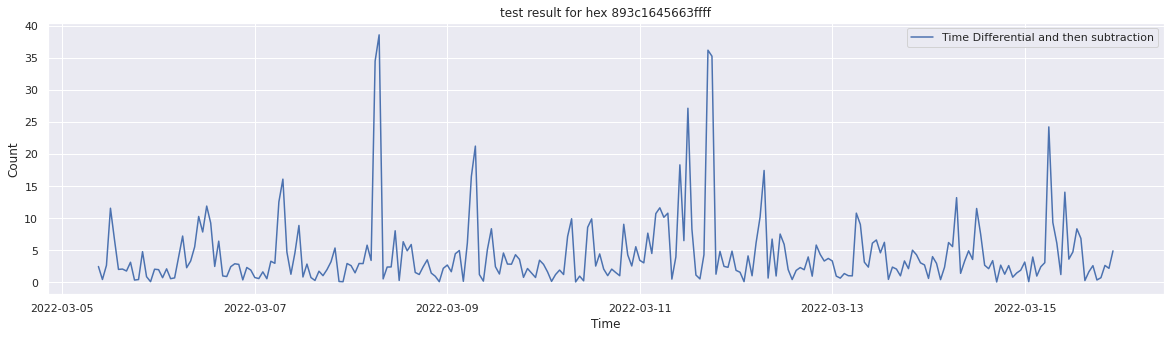

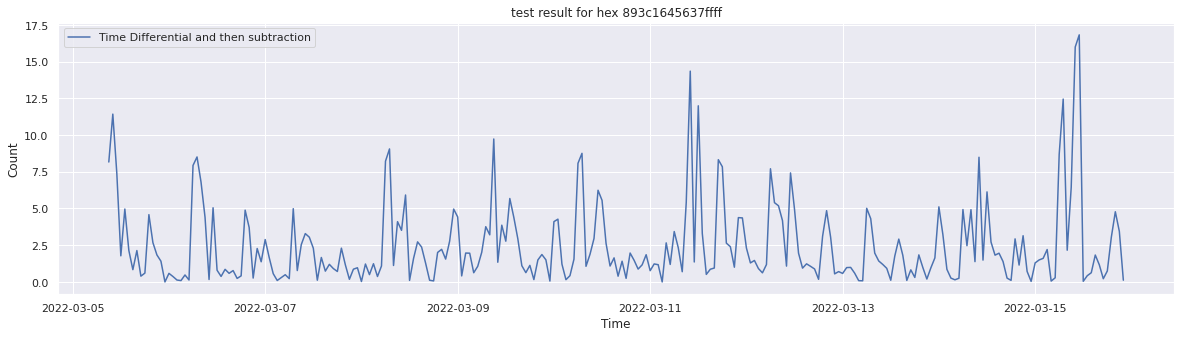

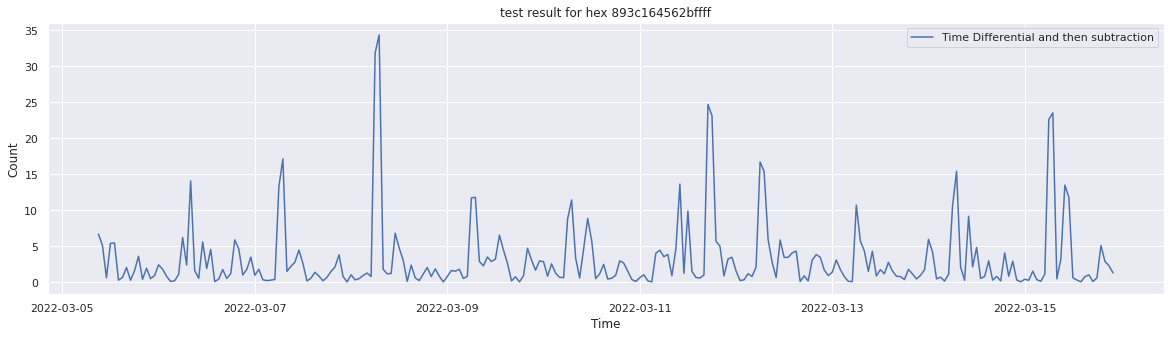

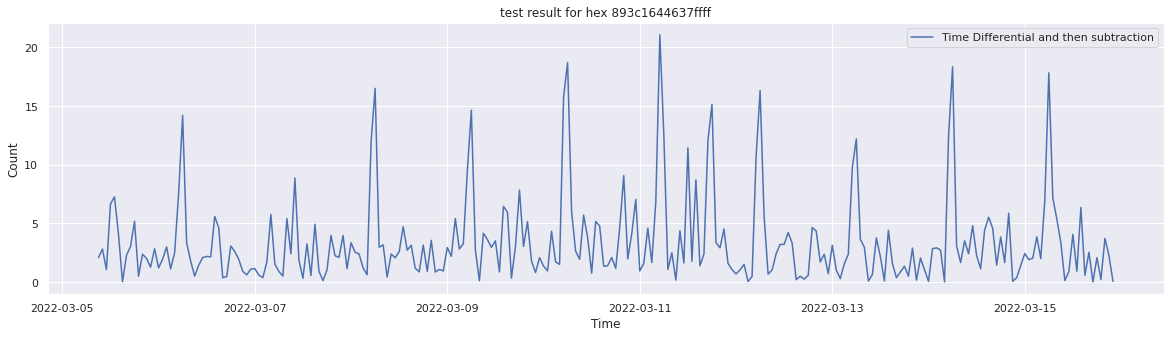

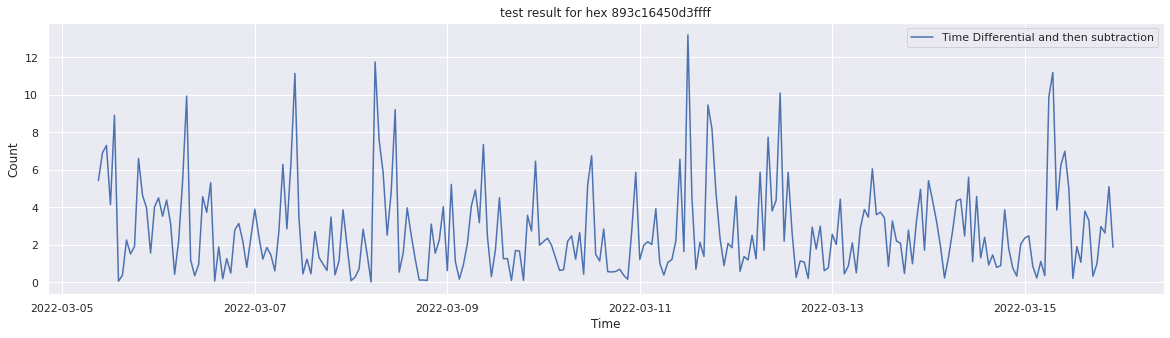

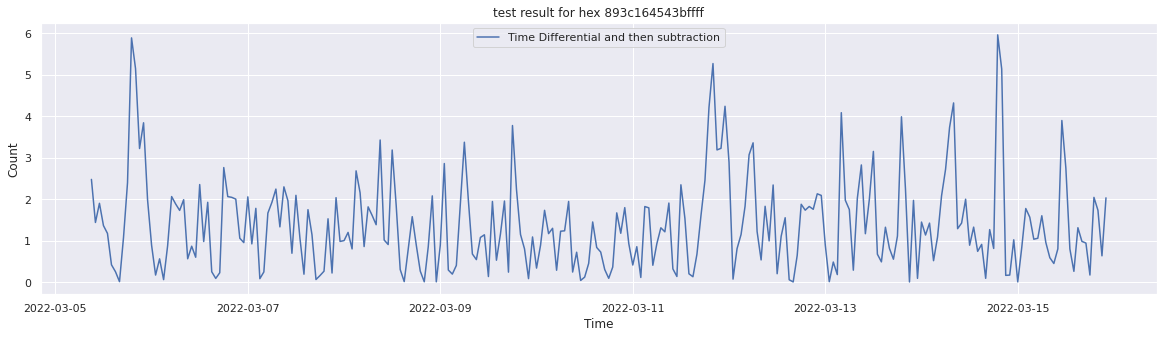

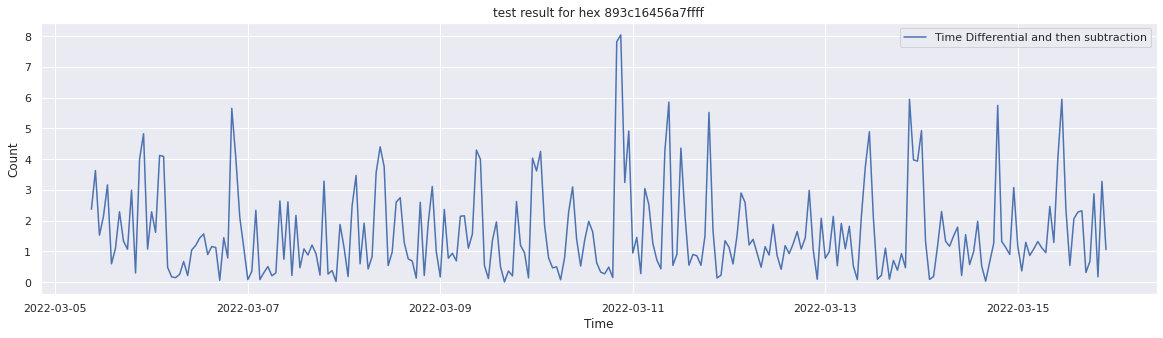

array([[2.54191232, 3.8010428 , 0.99398136, ..., 5.41526985, 2.47555923,
        2.36662054],
       [4.42848897, 0.6744926 , 0.15701866, ..., 6.88622332, 1.43810654,
        3.6251955 ],
       [1.678738  , 2.20390344, 0.19235992, ..., 7.29113102, 1.89962864,
        1.52228737],
       ...,
       [0.31675112, 0.4293499 , 5.75801194, ..., 2.61603808, 1.73196256,
        0.16832757],
       [0.57927573, 0.09660053, 1.94548655, ..., 5.08663607, 0.6341598 ,
        3.27266431],
       [0.01597857, 1.97410488, 0.01998401, ..., 1.85326576, 2.0308969 ,
        1.053895  ]])

In [50]:

start_date=datetime(2022,3,15,23)-timedelta(hours=test_ex_per_hour)
x=[start_date+timedelta(hours=i) for i in range(1,test_ex_per_hour)]
diff_data
for index in range(0,13):
  a_true=y_true[:,index]
  a_true_diff=differential(a_true)
  a_pred=y_pred[:,index]
  a_pred_diff= differential(a_pred)
  plt.figure(figsize=(20,5))
  y1=abs(a_true_diff-a_pred_diff)
  sns.lineplot(y=y1,x=x,label='Time Differential and then subtraction')
  plt.title(f'test result for hex {hex[index]}')
  plt.xlabel('Time')
  plt.ylabel('Count')
  plt.show()
    


In [112]:
print(y_pred.shape)
print(diff_data.shape)

(255, 13)
(255, 13)


[datetime.datetime(2022, 3, 8, 6, 0) datetime.datetime(2022, 3, 9, 6, 0)
 datetime.datetime(2022, 3, 15, 10, 0)]


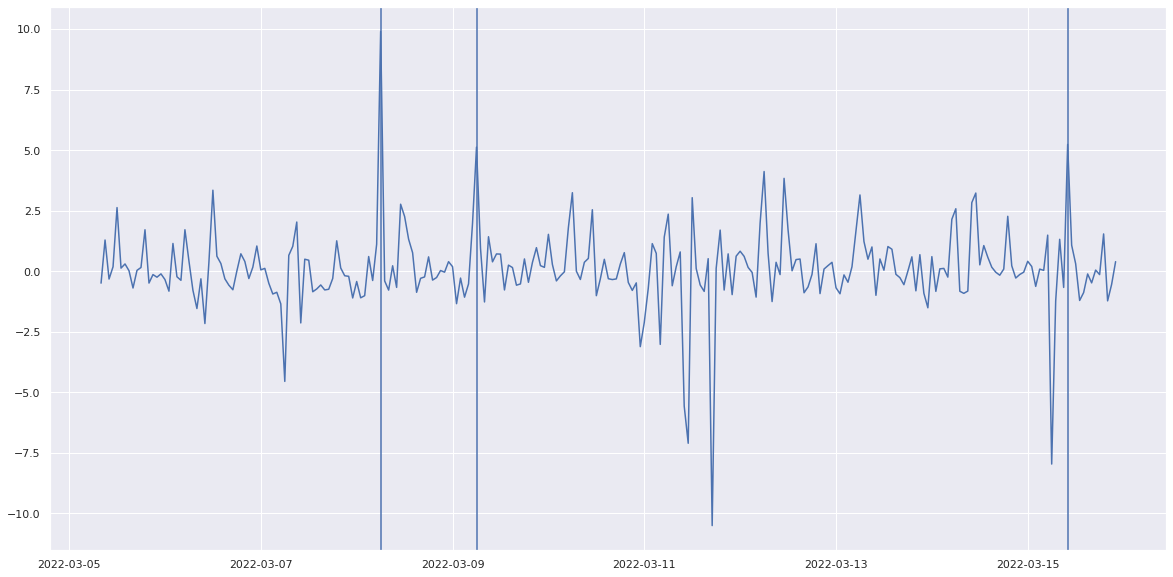

In [117]:
mn = np.mean(diff_data, axis=1)
crit_idx = np.where((mn > 5))

mn_crit = mn[crit_idx]
x_crit = np.array(x)[crit_idx]
print(x_crit)

plt.figure(figsize=(20,10))
plt.plot(x, mn)
for xs in x_crit:
    plt.axvline(xs)
    
    
